<a href="https://colab.research.google.com/github/ParalelaUCM/biciMAD/blob/master/PracticaSpark_BiciMad_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

Instalamos y configuramos las herramientas necesarias para empezar a trabajar

In [0]:
!apt-get install openjdk-8-jdk
"""
#!apt install unzip ya no lo usamos
"""
!apt-get install unrar
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!pip install pyspark

In [0]:
import json
import os
import matplotlib.pyplot as plt
import statistics as stats
from pyspark import SparkContext

In [0]:
sc = SparkContext()

# **Descargamos los datasets de bicimad**
Descargaremos cada dataset de la web oficial de biciMAD.
La función descarga usa los paquete Beautiful Soup y request, automatizando la obtención de los archivos. Los renombraremos a '.zip' o '.rar' para poder descomprimirlos y una vez descomprimidos los movemos a la carpeta 'datasets'. Por último eliminamos los ficheros comprimidos.

In [0]:
#Estructura de carpetas para el dataset
!mkdir dataset
!cd dataset/
!mkdir dataset/usages
!mkdir dataset/stations

In [0]:
!pip install patool

from bs4 import BeautifulSoup
import requests
import os
import zipfile
import patoolib

#datos de páginas web para la descarga de los dataset
pagina = "https://opendata.emtmadrid.es"
url = requests.get("https://opendata.emtmadrid.es/Datos-estaticos/Datos-generales-(1)")
html_doc = url.text
soup = BeautifulSoup(html_doc, 'html.parser')
meses_l = [None, "enero","febrero","marzo","abril","mayo","junio","julio",
           "agosto","septiembre","octubre","noviembre","diciembre"]

     |████████████████████████████████| 81kB 2.2MB/s 


In [0]:
def descarga(mes,año):
  for link in soup.find_all('a'):
    l = link.get('title')
    if isinstance(l,str):
      if meses_l[mes] in l.lower() and str(año) in l:
        if "uso" in l:
          print(l)
          enlace = link.get('href')
          url = pagina+enlace
          r = requests.get(url, allow_redirects=True)
          open('temp.aspx', 'wb').write(r.content)
          os.rename("temp.aspx","temp.zip")
          try:
            with zipfile.ZipFile("/content/temp.zip", 'r') as zip_ref:
              zip_ref.extractall("/content/dataset/usages")
            os.remove("/content/temp.zip")
          except:
            os.rename("temp.zip","temp.rar")
            patoolib.extract_archive("temp.rar", outdir="/content/dataset/usages")
            os.remove("/content/temp.rar")
        elif "estaciones" in l:
          print(l)
          enlace = link.get('href')
          url = pagina+enlace
          r = requests.get(url, allow_redirects=True)
          open('temp.aspx', 'wb').write(r.content)
          os.rename("temp.aspx","temp.zip")
          try:
            with zipfile.ZipFile("/content/temp.zip", 'r') as zip_ref:
              zip_ref.extractall("/content/dataset/stations")
            os.remove("/content/temp.zip")
          except:
            os.rename("temp.zip","temp.rar")
            patoolib.extract_archive("temp.rar", outdir="/content/dataset/stations")
            os.remove("/content/temp.rar")

In [0]:
for i in range(1,7):
  descarga(i,2019)

# **Creamos los RDD**
Una vez tenemos las bases de datos descargadas vamos a codificarlas de forma cómoda.

Para tener los datos almacenados de una forma cómoda primero creamos un diccionario cuya clave va a ser un string con el mes y el año del dataset y como valor va a tener el rdd asociado al uso por usuario de ese mes.

La funcion `mapper_usages` nos servirá para crear la rdd más legible. Nos quedaremos con los datos necesarios y cada linea la codificaremos como un diccionario.

In [0]:
rdd_usages = {} 

In [0]:
def mapper_usages(line):
  data = json.loads(line)
  user = data['user_type']
  user_day = data['user_day_code']
  start = data['idunplug_station']
  end = data['idplug_station']
  date = data['unplug_hourTime']['$date'][0:10]
  hora = data['unplug_hourTime']['$date'][11:19]
  time = data['travel_time']
  age = data['ageRange']
  try:
    track = data['track']
  except:
    track = None
  return {"user_type": user,
          "user_day_code": user_day,
          "start": start,
          "end": end,
          "travel_time": time,
          "date": date,
          "hour": hora,
          "age": age,
          "track": track}

In [0]:
directory = 'dataset/usages'
for filename in os.listdir(directory):
    if filename.endswith(".json"):
      #Nos quedamos con la fecha del dataset en formato YYYYMM
      name = filename.split("_")[0]
      rdd_usages[name] = sc.textFile(os.path.join(directory, filename)).map(mapper_usages)
      #DEBUG starts
      print(name)
      #DEBUG ends
    else:
        continue

201906
201905
201901
201904
201902
201903


In [0]:
#Juntamos todos los datos de los meses en uno solo dataset, y lo metemos también al diccionario.
rdd_usages['2019_01a06'] = rdd_usages['201901'].union(rdd_usages['201902'].union(rdd_usages['201903'].union(rdd_usages['201904'].union(rdd_usages['201905'].union(rdd_usages['201906'])))))
#rdd_usages['2019_01a06'] = rdd_usages['201901'].concat(rdd_usages['201902'])

In [0]:
rdd_usages['2019_01a06'].take(1)

[{'age': 0,
  'date': '2019-01-01',
  'end': 83,
  'hour': '00:00:00',
  'start': 82,
  'track': {'features': [{'geometry': {'coordinates': [-3.6803143, 40.4048615],
      'type': 'Point'},
     'properties': {'secondsfromstart': 153,
      'speed': 1.77,
      'var': '28007,ES,Madrid,Madrid,AVDA MENENDEZ PELAYO 117,Madrid'},
     'type': 'Feature'},
    {'geometry': {'coordinates': [-3.67770349972222, 40.4029987997222],
      'type': 'Point'},
     'properties': {'secondsfromstart': 93,
      'speed': 6.58,
      'var': '28007,ES,Madrid,Madrid,AVDA CIUDAD DE BARCELONA 51,Madrid'},
     'type': 'Feature'},
    {'geometry': {'coordinates': [-3.67432209972222, 40.4009430997222],
      'type': 'Point'},
     'properties': {'secondsfromstart': 32,
      'speed': 4.72,
      'var': '28007,ES,Madrid,Madrid,AVDA CIUDAD DE BARCELONA 81,Madrid'},
     'type': 'Feature'}],
   'type': 'FeatureCollection'},
  'travel_time': 162,
  'user_day_code': 'b3b5b61509ab89afbf4d1e589d229bebe6637c2de819f5d61

Por otro lado un diccionario cuya clave va a ser tambien un string con el mes y el año del dataset y como valor va a tener el rdd asociado a la ocupación de las estaciones en ese mes.

Aquí usaremos la funcion `mapper_stations` para acomodar los datos.

In [0]:
rdd_stations = {} 

In [0]:
def mapper_stations(line):
  data = json.loads(line)
  day = data['_id'][0:10]
  hour = data['_id'][11:27]
  station = data['stations']
  return {"day": day, "hour": hour, "station": station}

In [0]:
directory = 'dataset/stations'
for filename in os.listdir(directory):
    if filename.endswith(".json"):
      #Nos quedamos con la fecha del dataset en formato YYYYMM
      name = filename.split("_")[2].split(".")[0]
      rdd_stations[name] = sc.textFile(os.path.join(directory, filename)).map(mapper_stations)
      #DEBUG starts
      print(name)
      #DEBUG ends
    else:
        continue

201905
201906
201903
201902
201904
201901


# **Análisis de los 6 meses disponibles de 2019**

In [0]:
"""
#Para usar dataFrames que puede ser interesante (No he usado nada de esto abajo)
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read.json("/content/dataset/201901_Usage_Bicimad.json")
df.show()
"""

### **Analisis y comparativas entre datos nocturnos y diurnos.**

Lo primero que haremos será ver el número de usuarios diferenciados por tipos según sean horas diurnas o nocturnas.

Tomaremos como 'horas nocturnas' las horas comprendidas entre las 00:00 y las 05:59. Aunque como en los archivos de bicimad solo se distinguen las horas exactas, nuestras referencias nocturnas serán las 00:00, 01:00, 02:00, 03:00, 04:00 y 05:00.

In [0]:
"""
Con esta funcón, lo que hacemos es quedarnos solo con los datos del rdd, que sean nocturnos.

def horasNocturnas(data):
  #data = json.loads(line)
  #hora_minima = 3600 #Esto seria pasar las 01:00:00 horas a segundos‬
  hora_minima = 0 #Lo pongo en 0 ya que si no estamos perdiendo algun dato relevante para el ultimo problema
  hora_maxima = 18000 #Esto seria pasar las 05:00:00 horas a segundos‬
  hora = data['hour']
  hora_actual = int(hora[0:2]) * 3600 + int(hora[3:5]) * 60 + int(hora[6:8])
  #En teoria con multipicar solo las horas ya valdria porque no hay ni minutos ni segundos
  return hora_actual <= hora_maxima
"""

In [0]:
"""
Con esta función nos quedamos solo con los datos del rdd que sean nocturnos.
"""
def horasNocturnas(data):
  hora_minima = 0
  hora_maxima = 6
  hora_actual = int(data['hour'][:2])
  if hora_minima < hora_maxima:
    return hora_minima <= hora_actual and hora_actual < hora_maxima
  elif hora_minima > hora_maxima:
    return hora_minima <= hora_actual or hora_actual < hora_maxima

In [0]:
"""
Ahora tomamos el rdd que contiene los 6 meses de enero de 2019 a julio de 2019.
"""
rddNocturna = rdd_usages['2019_01a06'].filter(lambda x: horasNocturnas(x))

In [0]:
rddNocturna.take(1)

In [0]:
"""
Separamos ahora por tipo de usuario y vemos cuantos hay de cada tipo en total (para caso nocturno).
"""
night_data = rddNocturna.map(lambda x: x['user_type']).countByValue()
night_data

defaultdict(int, {0: 203, 1: 154927, 2: 1381, 3: 23428})

Creamos una gráfica para ver mejor los datos.

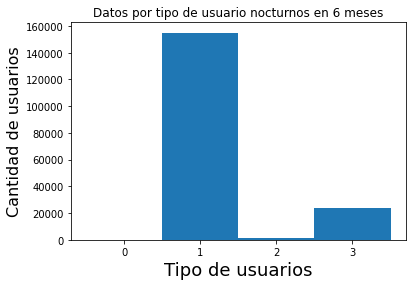

In [0]:
plt.title('Datos por tipo de usuario nocturnos en 6 meses')
names = list(night_data.keys()) 
values = list(night_data.values())
plt.bar(names, values, 1)
plt.xlabel('Tipo de usuarios', fontsize=18)
plt.ylabel('Cantidad de usuarios', fontsize=16)
names.sort()
plt.xticks(names, ["0","1","2","3"])
plt.show()

Podemos observar como la mayoría de usuarios que han usado bicimad por la noche son usuarios del tipo 1, que son los usuarios anuales mientras que hay muy pocos usuarios ocasionales. 

Para ver los datos diurnos, tomaremos los datos que están comprendidos entre las 06:00 y las 23:59.

In [0]:
"""
rddDiurna =  rdd_usages['2019_01a06'].filter(horasDiurnas)
"""
rddDiurna =  rdd_usages['2019_01a06'].filter(lambda x: not(horasNocturnas(x)))

In [0]:
rddDiurna.take(1)

In [0]:
"""
Separamos ahora por tipo de usuario y vemos cuantos hay de cada tipo en total (para el caso diurno)
"""
day_data = rddDiurna.map(lambda x: x['user_type']).countByValue()
day_data

defaultdict(int, {0: 1646, 1: 1767639, 2: 25599, 3: 118387})

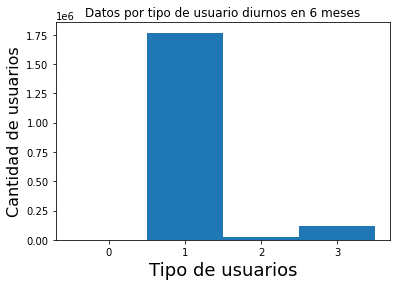

In [0]:
plt.title('Datos por tipo de usuario diurnos en 6 meses')
names = list(day_data.keys()) 
values = list(day_data.values())
plt.bar(names, values, 1)
plt.xlabel('Tipo de usuarios', fontsize=18)
plt.ylabel('Cantidad de usuarios', fontsize=16)
names.sort()
plt.xticks(names, ["0","1","2","3"])
plt.show()

Los datos de los histogramas son muy parecidos por lo que para ver la diferencia entre los datos nocturnos y los diurnos, es necesario hacer una proporcion para ver como son estos datos.

In [0]:
#Proporcion datos nocturnos
print("Proporción 'nocturna' entre tipo 2 sobre tipo 1: ", night_data[2]/night_data[1])

Proporción 'nocturna' entre tipo 2 sobre tipo 1:  0.008913875567202618


In [0]:
#Proporcion datos diurnos
print("Proporción 'diurna' entre tipo 2 sobre tipo 1: ", day_data[2]/day_data[1])

Proporción 'diurna' entre tipo 2 sobre tipo 1:  0.014482029418902842


Ambas proporciones son muy parecidas y bastante bajas por lo que los usuarios ocasionales no repercuten en gran medida en los datos ya que principalmente los usuarios son de tipo anual. Tambiés se puede se obserevar que, en las horas nocturnas, cuando podría haber una proporcion mayor de usuarios de tipo 2, no se puede concluir mediante estos datos

Las proporcion diurna, es un poquito más grande, luego, podemos decir que durante el día hay más usuarios de tipo 2 que durante la noche.

### **Análisis de días laborables y fines de semana**

Creemos que analizar los datos de los fines de semana puede darnos cierta información, dado que a priori, cabe pensar que habrá más movimientos, porque la gente puede estar fuera de casa hasta más tarde.

Lo primero que necesitamos es una función que nos diferencia entre días laborables y fines de semana. Tomaremos como fin de semana viernes, sábado y domingo.

In [0]:
"""
Utilizaremos la librería 'datatime', para obtener de forma sencilla el día de la semana qu es una fecha dada.
"""
from datetime import datetime, date, time, timedelta
import calendar
def cambioFormato(fecha):
  formato1 = "%A" #formatos: https://python-para-impacientes.blogspot.com/2014/02/operaciones-con-fechas-y-horas.html 
                            #https://blog.ipswitch.com/es/formato-de-fecha-en-python 
  dia=datetime.strptime(fecha, '%Y-%m-%d') #El segundo dato es el formato que tiene la fecha que le estoy dando
  dia_1=dia.strftime(formato1)
  return dia_1

In [0]:
def weekend(line, madrugada): #madrugada es un booleano para decirle si queremos que nos coja los días pero por la noche, en plan, en las horas nocturnas, pues queremos que nos coja, los sabados, los domingos y los lunes.
  #data=json.loads(line)
  if madrugada:
    days=['Saturday', 'Sunday', 'Monday']
  else:
    days=['Friday', 'Saturday', 'Sunday'] #por ejemplo si queremos los datos diurnos, pues lo pondríamos a 'not weekend(fecha, FALSE)', para que cogiese estos días
  dia=cambioFormato(line['date'])
  return dia in days

In [0]:
"""
#Esta funcion, dado cualquier dia, te dice si fue fin de semana o no en el año 2019. Tendiendo en cuenta
#que la 'noche' del viernes es sabado ya, por lo que queremos los dias sabado, domingo y lunes.
def is_weekend(data):
  months = [31, 28, 31, 30, 31, 30]#Los dias que tiene cada mes desde enero a junio
  #El 1 de enero de 2019 cayo en Martes
  fin_semana = [4,5,6] #Corrspondiente a los fines de semana.
  fecha_actual = data['date']
  mes_actual = int(fecha_actual[5:7])
  dia_actual = int(fecha_actual[8:10])
  dias_transcurridos = months[mes_actual-1]*(mes_actual-1) + dia_actual
  return dias_transcurridos % 7 in fin_semana
"""

In [0]:
rddWeekend=rddNocturna.filter(lambda x: weekend(x, True)) #madrugada a True porque estamos usando datos nocturnos.
weekend_data=rddWeekend.map(lambda x: x['user_type']).countByValue()
weekend_data

defaultdict(int, {0: 162, 1: 88006, 2: 954, 3: 8922})

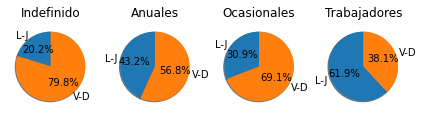

In [39]:
fig=plt.figure()
fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975)
fig.add_subplot(1,4,1)
plt.pie([night_data[0]-weekend_data[0], weekend_data[0]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Indefinido')
fig.add_subplot(1,4,2)
plt.pie([night_data[1]-weekend_data[1], weekend_data[1]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Anuales')
fig.add_subplot(1,4,3)
plt.pie([night_data[2]-weekend_data[2], weekend_data[2]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Ocasionales')
fig.add_subplot(1,4,4)
plt.pie([night_data[3]-weekend_data[3], weekend_data[3]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Trabajadores')
#plt.legend(['entre semana', 'fin de semana'], loc=4)
plt.show()

Como vemos, más de la mitad de viajeros que tienen pase anual, utilizan BiciMad en el fin de semana. Podemos ver que incluso casi el 70% de los viajes ocasionales se producen durante el fin de semana. Sin embargo, de los trabajadores de la empresa, solo el 38% lo hace en fin de semana.


In [0]:
"""
Esto de aqui abajo es nuevo, al hacerlo me ha parecido interesante y lo he añadido
"""

El porcentaje de los usuarios ocasionales es interesante compararlo con el estudio que habíamos realizado antes. En ese caso no se observaba una diferencia notable de este tipo de usuarios entre las horas nocturnas y las diurnas, pero sin embargo, ahora si que hay una clara diferencia teniendo en cuenta tan solo los días en horas nocturnas. Esto se puede deber a que, como sale más gente joven, hagan uso de bicimad para desplazarse. Veamos si es cierto.

In [60]:
nightAges_tipe2 = rddNocturna.filter(lambda x: x['user_type'] == 2).map(lambda x: x['age']).countByValue()
weekendAges_tipe2 = rddWeekend.filter(lambda x: x['user_type'] == 2).map(lambda x: x['age']).countByValue()
print(nightAges_tipe2)
print(weekendAges_tipe2)

defaultdict(<class 'int'>, {0: 1334, 3: 16, 4: 23, 5: 8})
defaultdict(<class 'int'>, {0: 924, 3: 9, 4: 14, 5: 7})


La mayoría de las edades son del tipo 0, que son aquellas que no están identificadas por lo que con estos datos no podemos extraer ninguna información sobre los usuarios de tipo ocasional.

Veamos ahora, los movimientos por horas.


In [0]:
def movimientosPorHoras(data):
  hora= data['hour']
  user=data['user_type']
  return hora, user

Tomamos los movimientos por horas nocturnos:

In [66]:
#rddHoras=rddNocturna.map(movimientosPorHoras)
time_data=rddNocturna.map(movimientosPorHoras).countByKey()
time_data

defaultdict(int,
            {'00:00:00': 59407,
             '01:00:00': 43304,
             '02:00:00': 31143,
             '03:00:00': 19471,
             '04:00:00': 14793,
             '05:00:00': 11821})

Tomamos los movimientos por horas en fin de semana:

In [67]:
#rddHorasWeekend=rddWeekend.map(movimientosPorHoras)
weekend_time_data = rddWeekend.map(movimientosPorHoras).countByKey()
weekend_time_data

defaultdict(int,
            {'00:00:00': 26845,
             '01:00:00': 23227,
             '02:00:00': 18568,
             '03:00:00': 13009,
             '04:00:00': 9402,
             '05:00:00': 6993})

Creamos dos gráficos, uno con los días laborables y otro con los fines de semana.

In [68]:
"""
Para obtener los días laborables, tenemos que 'restar' los datos de los fines de semana a los totales.
"""
laborable_time_data={}
for i in range(0,6):
  laborable_time_data['0'+str(i)+':00:00']=time_data['0'+str(i)+':00:00'] - weekend_time_data['0'+str(i)+':00:00']
laborable_time_data

{'00:00:00': 32562,
 '01:00:00': 20077,
 '02:00:00': 12575,
 '03:00:00': 6462,
 '04:00:00': 5391,
 '05:00:00': 4828}

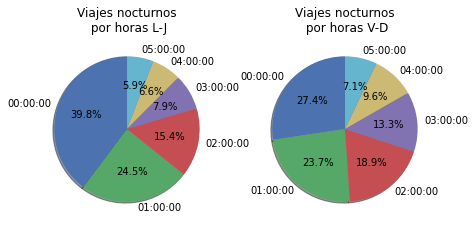

In [69]:
fig=plt.figure()
fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975)
fig.add_subplot(1,2,1)
plt.pie(list(laborable_time_data.values()), labels=list(laborable_time_data.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Viajes nocturnos\n por horas L-J')
fig.add_subplot(1,2,2)
plt.pie(list(weekend_time_data.values()), labels=list(weekend_time_data.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Viajes nocturnos\n por horas V-D')
plt.show()

NO SÉ POR QUÉ SE ME QUEDA ESO RARO EN LO DE LOS FINES DE SEMANA!!!!


Como vemos, los días laborables, casi el 65% de los viajes, se realizan antes de las 2 de la madrugada y sin embargo, este porcentaje se reduce al 51% cuando hablamos de los fines de semana, donde incrementa el número de viajes a partir de las 2 de la madrugada.

Para entenderlo mejor, veamos también distinciones por horas y usuarios.

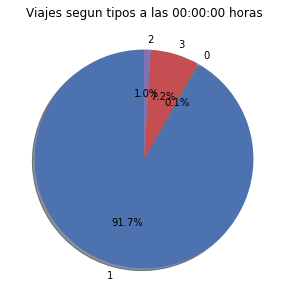

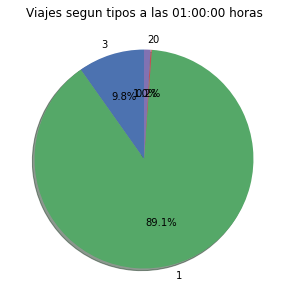

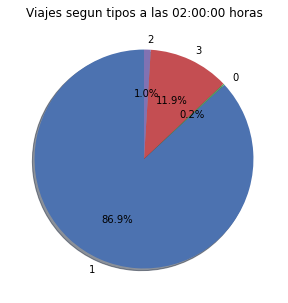

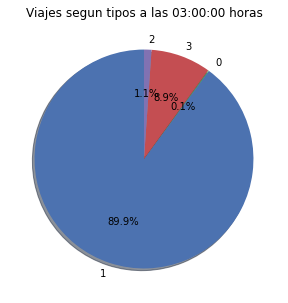

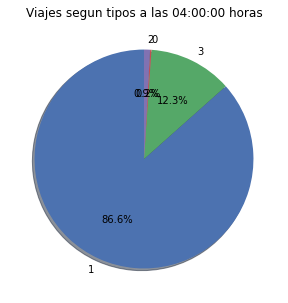

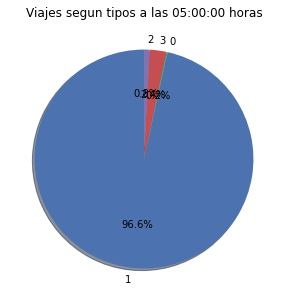

In [73]:
horas = ['00:00:00','01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00']
#fig=plt.figure()
#fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975) 
#fig.add_subplot(3,5,1)
def grafica(dic, value):
  fig=plt.figure()
  fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975) 
  #linea = value/2 +1
  #pos = (value % 2) + 1
  #fig.add_subplot(linea,5,pos)
  plt.pie(list(dic.values()), labels=list(dic.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
  plt.title('Viajes segun tipos a las '+horas[value]+' horas')
  plt.show()
for i in range(len(horas)):
  #grafica(rddHoras.filter(lambda x: x[0] == horas[i]).map(lambda x: (x[1], 1)).countByKey(), i)
  grafica(rddWeekend.map(movimientosPorHoras).filter(lambda x: x[0] == horas[i]).map(lambda x: (x[1], 1)).countByKey(), i)
#Tarda un rato y he intentado ponerlo como lo ponia elisa pero quedaba muy pequeño y no se absolutamente nada. Asi se ve mas pero a lo mejor
#ocupa demasiado.

Como ya habíamos visto, la mayoría de los trayectos que se realizan son por los usuarios de tipo 1, los anuales, pero también hay que tener en cuenta que entre las 1 horas, 2 horas y 4 horas, hay más de un 15% de los viajes que son realizados por los trabajadores de la empresa. Mientras que a las 12 y a las 3 de la madrugada, no superan el 10%. Por esto, será interesante realizar un estudio de los trabajadores más adelante.
 

### **Análisis por rango de edades**

Otro punto interesante, seria estudiar la diferencia en los usos segun los rangos de edad

[(0, 51330), (1, 1320), (2, 695), (3, 7748), (4, 24374), (5, 12343), (6, 234)]


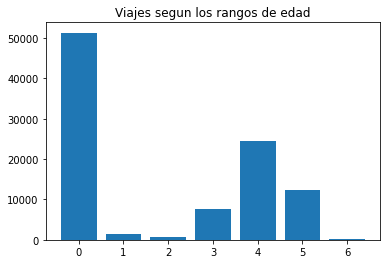

In [0]:
#Empezemos estudiando los usos nocturnos en fines de semana.
"""
Tenemos en cuenta que:
0: no se identifica
1: entre 0 y 16 años
2: entre 17 y 18 años
3: entre 19 y 26 años
4: entre 27 y 40 años
5: entre 41 y 65 años
6: 66 años o más
"""
rddW_ages = rddWeekend.map(lambda x: (x['age'], 1)).countByKey()
print(sorted(rddW_ages.items(), key=lambda x:x[0]))
plt.bar(list(rddW_ages.keys()), list(rddW_ages.values()))
plt.title('Viajes segun los rangos de edad')
plt.show()

A parte de los usuarios no identificados, los que más hacen un uso nocturno los fines de semana son los que están en la franja de edad de entre 27 y 40 años, lo que nos puede indicar que parte de la gente que utiliza bicimad es gente joven. Veamos ahora si este comportamiento es similiar a los dias entre semana.

In [0]:
"""
#Esta funcion, dado cualquier dia, te dice si fue fin de semana o no en el año 2019. Tendiendo en cuenta
#que la 'noche' del viernes es sabado ya, por lo que queremos los dias sabado, domingo y lunes.
#Como ahora nos interesan los dias entre diario, pues cogemos aquellos que no sean fin de semana.
def is_workDays(data):
  months = [31, 28, 31, 30, 31, 30]#Los dias que tiene cada mes desde enero a junio
  #El 1 de enero de 2019 cayo en Martes
  fin_semana = [4,5,6] #Corrspondiente a los fines de semana.
  fecha_actual = data['date']
  mes_actual = int(fecha_actual[5:7])
  dia_actual = int(fecha_actual[8:10])
  dias_transcurridos = months[mes_actual-1]*(mes_actual-1) + dia_actual
  return dias_transcurridos % 7 not in fin_semana
"""

In [0]:
"""
def workDays(line):
  #Como en realidad queremos las noches, 'la noche del vierne' sería el sabado ya, entonces, buscamos los
  #días: 5,6,7,12,13,14,19,20,21,26,27,28.
  #Como estos son los dias de fin de semana, necexitamos coger los dias que no estan en esta lista simplemente
  data=json.loads(line)
  days=['2019-01-05', '2019-01-06', '2019-01-07','2019-01-12','2019-01-13','2019-01-14', '2019-01-19', '2019-01-20','2019-01-21','2019-01-26', '2019-01-27', '2019-01-28']
  dia_actual=data['unplug_hourTime']['$date'][0:10]
  return dia_actual not in days
"""

In [0]:
#Partimos de la RDD que tenia los datos filtrados por las horas nocturnas,
#y con poner en filter, que no sea fin de semana, tendremos los días laborables.
rddWD_ages = rddNocturna.filter(lambda x: not weekend(x, True)).map(lambda x: (x['age'])).countByValue()
print(sorted(rddWD_ages.items(), key=lambda x:x[0]))
plt.bar(list(rddWD_ages.keys()), list(rddWD_ages.values()))
plt.title('Viajes segun los rangos de edad en días laborables')
plt.show()

Aunque ambas gráficas son muy parecidas, mirando el numero exacto de datos, se observa un claro aumento de los usurios de tipo 3 y 4 en los fines de semana, que son aquellos cuyas edades están entre 19 y 26 años y entre 27 y 40 años respectivamente. Podemos suponer por lo tanto, que los usuarios jóvenes son los que más demanda tienen en horas nocturnas, y por ser más concretos, las personas mayores de edad. Además, hay que tener en cuenta que los datos recogidos los fines de semana se establecen en menos días que los datos de diario por lo que el porcentaje de crecimiento es aun mayor. 

Esto tiene bastante que ver con las gráficas vistas anteriormente en las que se observa claramente como hay un mayor uso los fines de semana.


En estos datos analizados, estamos teniendo en cuenta aquellos que se obtienen por los trabajadores de la empresa y como no nos interesan, veamos si hay algún cambio mayor suprimiendo a los trabajadores.

In [0]:
#eliminamos a los trabajadores de la empresa
rddWD_ages2 = rddNocturna.filter(lambda x: not weekend(x, True) and not(x[0]==3)).map(lambda x: (x['age'])).map(lambda x: (x[7], 1)).countByKey()
rddW_ages2 = rddWeekend.map(lambda x: (x['age'], 1)).filter(lambda x: not(x[0] == 3)).map(lambda x: (x[7], 1)).countByKey()
print("Días laborables:", sorted(rddWD_ages2.items(), key=lambda x:x[0]))
print("Fines de semana:", sorted(rddW_ages2.items(), key=lambda x:x[0]))

Los datos son muy parecidos, aunque se observa, como habiamos visto antes un mayor decrecimiento en los datos diarios ya que hay un mayor uso por parte de los trabajdores.

Esto de aqui abajo lo he hecho pero no sabia por que y lo he dejado asi jaja

In [0]:
#Esta RDD ya tiene los datos importantes usando la funcion mapper        
rddNocturna_ordenada = rddNocturna_datos.map(lambda x: (x[2], 1)).groupByKey().mapValues(tuple).map(lambda x: (len(x[1]), x[0]))
rddNocturna_ordenada.sortByKey(False).map(lambda x: (x[1], x[0])).take(50)

In [0]:
rddNocturna_datos.filter(lambda x: x[2] == 57).map(lambda x: (x[2], x[3])).take(30)

La estacion de la que parten mas bicis es de la 57, veamos que estaciones tienen como destino

## **Estaciones más y menos usadas**

Esto se me ha ocurrido hacerlo sobre la marcha y creo que estaría bien.

# **Comparativa entre un mes de invierno y un mes de verano**

AQUÍ SE SUPONE QUE VA LO MISMO QUE LO DE LOS 6 MESES PERO PARA CADA MES ENERO Y JULIO. eN TEORÍA SE IRÍA HACIENDO CADA COSA A LA VEZ EN LOS DOS MESESY SE VA COMPARANDO.

# **Pruebas berni**

In [0]:
#rdb es el rdd de los trabajadores
rdb = rdd_raw.map(mapper).filter(lambda x: x[0]==3).map(lambda x: ((x[1],[x[i] for i in range(2,7)])))
rdb.take(1)

In [0]:
#rdb por usuarios
rdbpu=rdb.groupByKey().mapValues(len)
rdbpu.count()
#hay 853, diferenciados por día (unos 43 trabajadores fijos??)
rdbpu.take(10)

In [0]:
#rdb por días
rdbpd = rdb.map(lambda x: (x[1][3][-3:],1))
rdbpd.take(2)
pd_dicc=rdbpd.countByKey()
pd_list = sorted(pd_dicc.items(), key=lambda x:x[0])
plt.figure(figsize=(15,5))
plt.bar(pd_dicc.keys(), pd_dicc.values())
#no nos da mucha info (quizá ver cuándo son los findes)

In [0]:
#rdb por horas
rdbph = rdb.map(lambda x: (x[1][4],x[0]))
rdbph.take(2)
ph_dicc=rdbph.countByKey()
ph_list = sorted(ph_dicc.items(), key=lambda x:x[0])
plt.figure(figsize=(15,5))
plt.bar(ph_dicc.keys(), ph_dicc.values())

In [0]:
def reparacion(line):
  #se trata de una reparación en la misma estación
  data = json.loads(line)
  user = data['user_type']
  start = data['idunplug_station']
  end = data['idplug_station']
  time = data['travel_time']
  return user==3 and start==end
def traslado(line):
  #se trata de una reparación en la misma estación
  data = json.loads(line)
  user = data['user_type']
  start = data['idunplug_station']
  end = data['idplug_station']
  time = data['travel_time']
  return user==3 and start!=end
def no_funciona (line):
  #se trata de una reparación en la misma estación
  data = json.loads(line)
  user = data['user_type']
  start = data['idunplug_station']
  end = data['idplug_station']
  time = data['travel_time']
  return user!=3 and start==end #and time < 121

In [0]:
#nos quedamos con las reparaciones
rddrep = rdd_raw.filter(reparacion).map(mapper)
repN = rddrep.count() #hay 5361 veamos cuantas son reparadas de verdad, o solo comprobadas
rddrep.take(1)

In [0]:
limite=61
repF=rddrep.filter(lambda x: x[4]<limite).map(lambda x:(x[4],1)).count()
repT=rddrep.filter(lambda x: x[4]>=limite).map(lambda x:(x[4],1)).count()

In [0]:
repF/(repN) #proporción del 95% de reparaciones rápidas
plt.figure(figsize=(10,4))
plt.bar(("reparaciones rápidas","reparaciones pausadas"),(repF,repT))

In [0]:
#nos quedamos con los traslados
rddtra = rdd_raw.filter(traslado).map(mapper)
traN = rddtra.count() #16115
rddtra.take(1)

In [0]:
repF/(repN) #proporción del 95% de reparaciones rápidas
plt.figure(figsize=(10,4))
plt.bar(("reparaciones","traslados"),(repN,traN))

In [0]:
#nos quedamos con los viajes en que no funciona la bici
rddnof = rdd_raw.filter(no_funciona).map(mapper)
nofN = rddnof.count() #16115
rddnof.take(1)

In [0]:
qwe = rddnof.map(lambda x: (x[4],1)).groupByKey().mapValues(len)
qwe.count()

In [0]:
#vamos a ver cuantos de los que cogen la bici por la noche la cogen luego otra vez en ese día
#sin contar trabajadores
rdda = rdd_raw.map(mapper).filter(lambda x: x[0]!=3).map(lambda x: ((x[0],x[1]),tuple(x[2:7])))
rdda.take(2)

In [0]:
a1 = rdda.groupByKey().mapValues(len).filter(lambda x: x[1]==1).count() #cuantos hacen solo un viaje:  89036

In [0]:
a2 = rdda.groupByKey().mapValues(len).filter(lambda x: x[1]!=1).count() #cuantos hacen mas de un viaje: 68954

In [0]:
rddan = rdda.map(lambda x: (x[0],int(x[1][4])))

In [0]:
rddan.take(1)

In [0]:
def to_list(a):
    return [a]

def append(a, b):
    a.append(b)
    return a

def extend(a, b):
    a.extend(b)
    return a

In [0]:
qwe = rddan.combineByKey(to_list, append, extend).map(lambda x: (sorted(x[1]),x[0]))

In [0]:
qwe.take(3)

In [0]:
qwe1 = qwe.filter(lambda x: len(x[0])==1 and min(x[0])<6)
qwe2 = qwe.filter(lambda x: len(x[0])>1 and min(x[0])<6)

In [0]:
qwe1.count() #10698 la usan solo una vez

In [0]:
qwe2.count() #7915 la usan más veces además de en horario nocturno

In [0]:
#ahora vemos de estos las proporciones de usuarios de tipo 1 y 2
qwe11=qwe1.filter(lambda x: x[1][0]==1).count()
qwe12=qwe1.filter(lambda x: x[1][0]==2).count()

In [0]:
qwe21=qwe2.filter(lambda x: x[1][0]==1).count()
qwe22=qwe2.filter(lambda x: x[1][0]==2).count()

# **PROBLEMA**
  Un usuario desea viajar de una estación a otra en una cierta hora pero no sabe como será la disponibilidad de bicicletas en ese sitio ni si habrá sitio en el lugar de destino, por lo que basando en el historial de ese mismo mes, veremos si el cliente podrá realizar su viaje sin problemas o habrá que recoemndarle rutas alternativas

In [0]:
origen = input('Estación de la que se desea partir: ')
destino = input('Estación a la que se desea llegar: ')
hora_Viaje = input('Hora a la que se desea realizar el viaje: ')  

Voy a hacer un filtrado simple del fichero de datos de las situaciones de las estaciones para ver como podriamos obtener la informacion que nos interesa dependiendo de la estacion del cliente.

In [0]:
#Hagamos una lista con los datos de todas las estaciones para tenerlos a 
def crearDiEst(lista):
  dicEstac = {}
  for station in lista:
    dicEstac[station['number']] = {}
    dicEstac[station['number']]['id'] = station['id']
    dicEstac[station['number']]['latitude'] = station['latitude']
    dicEstac[station['number']]['longitude'] = station['longitude']
    dicEstac[station['number']]['name'] = station['name']
    dicEstac[station['number']]['total_bases'] = station['total_bases']
  return dicEstac

listEstacion = rdd_stations['201901'].map(lambda x: crearDiEst(x['station'])).take(1)
dicEstaciones = listEstacion[0]
dicEstaciones['57']#Datos de la estacion 57

In [0]:
#Intentemos ver ahora la probabilidad de encontrar bici a la hora que nos dice el cliente.
#De momento establezco yo la hora por comodidad, la estacion de origen y destino tambien
origen = '57'
destino = '38'
horaCliente = '03:00:00'

In [0]:
#De todas las estaciones que hay en todos los datos vamos a intentar quedarnos tan solo con los que son de la estacion que queremos
def estaciones(lista):
  filtro = []
  for estacion in lista['station']:
    if estacion['number'] == origen or estacion['number'] == destino:
      filtro.append(estacion)
  return {"day":lista['day'],
          "hour":lista['hour'],
          "station":filtro}

rddE_Sit_fil = rdd_stations['201901'].map(estaciones)
rddE_Sit_fil.take(3)


In [0]:
#Veamos ahora la probabilidad de que el usuario encuentre una bici disponible en la estacion de partida

def filtPorHora(hora, rango):
    horaViaje = int(horaCliente[0:2]) * 3600 + int(horaCliente[3:5]) * 60 + int(horaCliente[6:8])
    horaDatos = int(hora[0:2]) * 3600 + int(hora[3:5]) * 60 + int(hora[6:8])
    if horaViaje - rango < 0:
      return horaDatos < horaViaje + rango
    else:
      return horaViaje - rango < horaDatos < horaViaje + rango

def calcularBicisLibres(lista):
  #bicisLibres = []
  for station in lista:
    if station['number'] == origen:
      return station['dock_bikes'] - station['reservations_count']

bicisLibres = rddE_Sit_fil.filter(lambda x: filtPorHora(x['hour'], 3600)).map(lambda x: [calcularBicisLibres(x['station'])]).reduce(lambda a, b: a+b)

print('La media de bicicletas libres respecto a la hora elegida es:',int(stats.mean(bicisLibres)))
#La media esta realizada para los datos obtenidos en el rango una hora respecto a la dicha por el cliente

#Por lo tanto la probabilidad de que encuentre una bici disponible es la siguiente
basesTotales = dicEstaciones[origen]['total_bases']
prob = sum(bicisLibres) / (basesTotales * len(bicisLibres))
print('La probabilidad de que haya una bicicleta libre es del', str(100*prob)+'%')

Antes de esto que esta hecho, podriamos hacer unas graficas indicando las hora en las que se hacen esos viajes, si son mas comunes en fin de semana o entre semana... (Le podemos dar el toque nocturno y ademas usar todo lo que esta arriba de los graficos que tiene relacion con esto)

Primero vamos a hacer un analisis del viaje que quiere realizar el cliente

In [0]:
rddInvierno_viaje = rdd_usages['2019_01a06'].filter(lambda x: x['start'] == int(origen) and x['end'] == int(destino))
print('Total de viajes similares al del cliente: ', rddInvierno_viaje.count())

In [0]:
#Veamos cuales son las horas mas comunes para realizar este tipo de viaje.
#fig = plt.figure()
dicc = rddInvierno_viaje.map(lambda x: (int(x['hour'][0:2]), 1)).countByKey()
dicc_list = sorted(dicc.keys())
plt.figure(figsize=(15,5))
plt.title("Usuarios que realizan el viaje "+origen+ " --> "+destino )
plt.bar(dicc.keys(), dicc.values())
plt.xlabel('Horas', fontsize=18)
plt.ylabel('Cantidad de usuarios', fontsize=16)
plt.show()
#plt.xticks(dicc.keys(), dicc_list) No he conseguido que se ponga el numero en todos los contenedores

In [0]:
#Veamos si hay alguna diferencia en el tipo de usuarios que han realizado el viaje
rddInvierno_viaje.map(lambda x: (x['user_type'], 1)).countByKey()

In [0]:
#Veamos la edad de los usuarios que predomina realizando este viaje. 
rddInvierno_viaje.map(lambda x: (x['age'], 1)).countByKey()

In [0]:
#Estudiemos ahora las medias en tiempo de todos los viajes, el coste del viaje, etc.
import statistics as stats
listaTiempos = rddInvierno_viaje.map(lambda x: ([x['travel_time']])).reduce(lambda a, b: a + b)
print('La media de tiempo empleado por otros usuarios es: ',stats.mean(listaTiempos), 'segundos')

Esta media de tiempo incluye los viajes a cualquier tipo de hora, pero los que nos interesan son los que se realizan por la noche. Veamos ahora si realizar este trayecto por el día o por la noche afecta en el tiempo medio para recorrer el trayecto. Con este analisis, se verá si afecta el tráfico ya que es el principal causante del incremento en el tiempo de un viaje

In [0]:
#Diferencias de los tiempos medios entre las horas nocturnas y las horas diurnas

tiemposNoc = rddInvierno_viaje.filter(horasNocturnas).map(lambda x: ([x['travel_time']])).reduce(lambda a, b: a + b)
tiemposDiu = rddInvierno_viaje.filter(horasDiurnas).map(lambda x: ([x['travel_time']])).reduce(lambda a, b: a + b)

In [0]:
mediaNocturna = stats.mean(tiemposNoc)
mediaDiurna = stats.mean(tiemposDiu)
print('Tiempo medio de viajes nocturnos es: ',mediaNocturna, 'segundos')
print('Tiempo medio de viajes diurnos es: ',mediaDiurna, 'segundos')
if mediaNocturna < mediaDiurna:
  print("\nEl tiempo para recorrer el trayecto si se ve afectado por el tráfico, reduciendolo, \nen las horas nocturnas")
else:
  print("El tráfico no afecta a este trayecto")

En caso de no tener claro el trayecto para llegar al destino, le indicaremos al cliente que calles han sido las más transitadas realizando el viaje que se desea hacer.

In [0]:
#Lo uso para ver como son los datos
rddInvierno_viaje.map(lambda x: x['track']).take(5)

In [0]:
#Tan solo estudiaremos los trayectos nocturnos para este caso ya que es lo que nos interesa.

def obtenerCalles(line):
  listaCalles = []
  data = line['track']
  for value in data['features']:
    try:
      calle = value['properties']['var'].split(",")
      listaCalles.append(calle[4])
    except:
      None
  if len(listaCalles) > 0:
    return ([listaCalles[-1]], [listaCalles[0]]) #Porque el primer dato es el último que se recibe (de ahí el -1).

rddInvierno_viaje.filter(horasNocturnas).filter(lambda x: x['user_type'] != 3 and x['track'] != None)\
.map(obtenerCalles).collect()#reduce(lambda x, y: [x[0] + y[0], x[1], y[1]])


Aqui faltaria todavia hacer el ranking

Hagamos ahora el mismo estudio que al principio y veamos la cantidad de huecos libres que hay en la estación de destino. 

In [0]:
def filtPorHora2(hora, rango):
    horaViaje = int(horaCliente[0:2]) * 3600 + int(horaCliente[3:5]) * 60 + int(horaCliente[6:8]) + mediaNocturna
    horaDatos = int(hora[0:2]) * 3600 + int(hora[3:5]) * 60 + int(hora[6:8])
    if horaViaje - rango < 0:
      return horaDatos < horaViaje + rango
    else:
      return horaViaje - rango < horaDatos < horaViaje + rango

def calcularBasesLibres(lista):
  #bicisLibres = []
  for station in lista:
    if station['number'] == destino:
      return station['free_bases']

basesLibres = rddE_Sit_fil.filter(lambda x: filtPorHora2(x['hour'], 3600)).map(lambda x: [calcularBasesLibres(x['station'])]).reduce(lambda a, b: a+b)

print('La media de bicicletas libres respecto a la hora elegida es:',int(stats.mean(basesLibres)))
#La media esta realizada para los datos obtenidos en el rango una hora respecto a la dicha por el cliente

#Por lo tanto la probabilidad de que encuentre una bici disponible es la siguiente
basesTotales = dicEstaciones[destino]['total_bases']
prob = sum(basesLibres) / (basesTotales * len(basesLibres))
print('La probabilidad de que haya una bicicleta libre es del', str(100*prob)+'%')